In [167]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
%matplotlib inline
from tqdm.auto import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [204]:
def magic(date):
    date = date[:4]+' '+date[5:7]+' '+date[8:]       
    return date[:18]

def show_criterion(subject,course_id,h_start=0, h_end=96):
    if h_start>=h_end:
        raise Exception(f'h_start>=h_end')
    path = f'courses_with_manual_check/{subject}/{course_id}/'
    try:
        solution_log = pd.read_csv(path+'solution_log.csv')
    except:
        raise Exception(f'No such file or directory',path,'solution_log.csv')
        
    solution_log = solution_log.dropna(subset=['review_time'])
    solution_log = solution_log.reset_index(drop=True)
    ###
    difference = []
    for i in range(len(solution_log['review_time'])):
        a = datetime.strptime(magic(solution_log['submission_time'][i]), '%Y %m %d %H:%M:%S')
        b = datetime.strptime(magic(solution_log['review_time'][i]), '%Y %m %d %H:%M:%S')
        difference.append(b - a)
    solution_log['time_of_expectation'] = difference
    solution_log = solution_log.drop(columns=['submission_time', 'review_time'])
    ###
    solution_log['hours_diff']=solution_log['time_of_expectation'].apply(lambda x: x.days*24+x.seconds//3600)
    pre_df = solution_log[['element_progress_id','hours_diff']]
    pre_df['id']=pre_df['element_progress_id'].astype(int)
    pre_df = pre_df.drop(columns=['element_progress_id'])
    
    try:
        user_element_progress = pd.read_csv(path+'user_element_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_element_progress.csv')
    user_element_progress['id'] = user_element_progress['id'].astype(int)
    user_element_progress.reset_index(drop=True)
    user_element_progress = user_element_progress[['id','user_id']]
    
    try:
        user_module_progress = pd.read_csv(path+'user_module_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_module_progress.csv')
    user_module_progress['is_achieved'] = user_module_progress['is_achieved'].fillna(False).astype(int)
    user_module_progress = user_module_progress[['user_id','is_achieved']]
    
    
    df = pre_df.merge(user_element_progress).merge(user_module_progress, on='user_id')
    
    """
    получили таблицу с колонками: element_progress_id, hours_diff, user_id, module_is_achieved
    """
    
    hours = np.arange(h_start,h_end)
    good = []
    I_error = []
    II_error = []
    bad = []
    for h in tqdm(hours):
        g = 0
        I_type = 0
        II_type = 0
        b = 0
        for u_id in df['user_id'].unique():
            total = len(df[df['user_id']==u_id])
            greater =  sum((df[df['user_id']==u_id]['hours_diff']>h))/total
            if greater<=0.1 and df[df['user_id']==u_id]['is_achieved'].iloc[0]==1: 
                g+=1
            elif greater<=0.1 and df[df['user_id']==u_id]['is_achieved'].iloc[0]==0:
                I_type+=1   
            elif greater>=0.1 and df[df['user_id']==u_id]['is_achieved'].iloc[0]==1:
                II_type+=1
            else:
                b+=1
        good.append(g)
        I_error.append(I_type)
        II_error.append(II_type)
        bad.append(b)
    
    total_passed = df.groupby(['user_id'])['is_achieved'].min().sum()
    total_students = len(df['user_id'].unique())
    
    good = np.array(good)/total_passed
    I_error = np.array(I_error)/(total_students-total_passed) 
    II_error = np.array(II_error)/total_passed
    bad = np.array(bad)/(total_students-total_passed)
    
    fig, axis = plt.subplots(1,1,figsize=(20,7))
    axis.plot(hours, good, label = '"Good" students', color='g')
    axis.plot(hours, I_error, label ='"I_error" students')
    axis.plot(hours, II_error, label = '"II_error" students')
    axis.plot(hours, bad, label='"bad" students',color='r')
    plt.legend(fontsize=14)
    axis.set_title(f'{subject}-{course_id}')
    axis.set_xlabel('hours')
    axis.set_ylabel('relative amount')
    plt.show()
    print(f"Минимальное время проверки: {df['hours_diff'].min()} часов, максимальное время проверки {df['hours_diff'].max()} часов")


### $ \{T_{i} > t \text{ часов } \} \le 0.1 $

  0%|          | 0/72 [00:00<?, ?it/s]

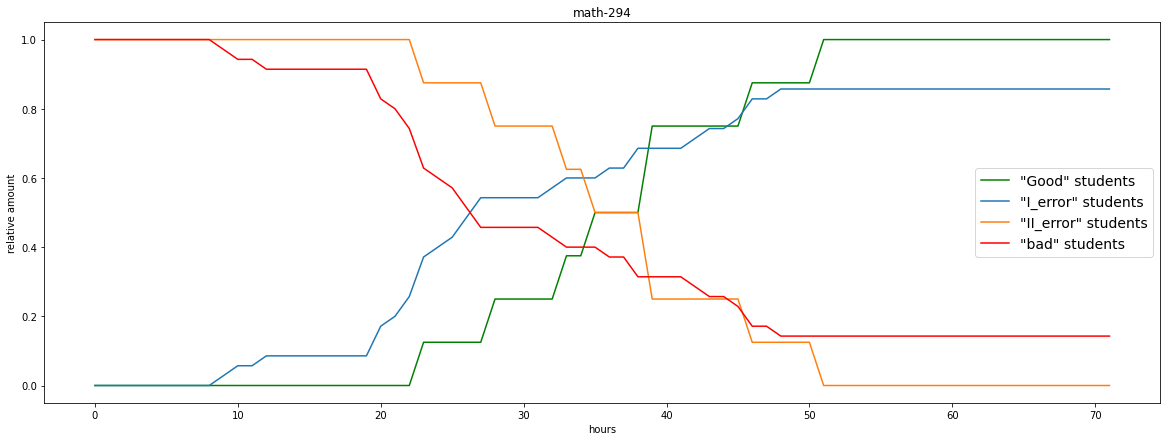

Минимальное время проверки: 0 часов, максимальное время проверки 274 часов


In [203]:
show_criterion('math','294',0, 72)